# Model 4 - UDE Framework (Multiple Experiments)

**System:**
$$\frac{dX}{dt} = f(Y) + aX(1 - X)$$
$$\frac{dY}{dt} = (bX - 1)Y$$

**Unknown:** Function $f(Y)$ and Parameters $a, b$

**Note:** This model has multiple experiments per dataset


In [174]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from ude_framework import (
    create_neural_network,
    create_ude,
    UDETrainer,
    UDEEvaluator
)

%matplotlib inline
np.random.seed(42)
torch.manual_seed(42)

print("✓ UDE Framework loaded!")


✓ UDE Framework loaded!


In [175]:
# ============================================================================
# CONFIGURE EVERYTHING HERE
# ============================================================================

# ----------------------------------------------------------------------------
# 1. DATA FILES
# ----------------------------------------------------------------------------
# Choose which dataset to use (1 or 2)
DATASET_NUMBER = 1

INITIAL_CONDITIONS_FILE = f'model_4_dataset_{DATASET_NUMBER}_initial_conditions.csv'
MEASUREMENTS_FILES = [
    f'model_4_dataset_{DATASET_NUMBER}_measurements_1.csv',
    f'model_4_dataset_{DATASET_NUMBER}_measurements_2.csv',
    f'model_4_dataset_{DATASET_NUMBER}_measurements_3.csv'
]

# State variable names
STATE_NAMES = ['X', 'Y']

# Which states are observed in measurements
OBSERVED_STATES = ['Y']  # Only Y is measured
OBSERVED_INDICES = [STATE_NAMES.index(name) for name in OBSERVED_STATES]

# ----------------------------------------------------------------------------
# 2. UDE STRUCTURE (partial known + NN for unknown)
# ----------------------------------------------------------------------------
def ude_ode_equations(t, y, nn_outputs, known_params):
    """
    UDE for Model 4:
    - KNOWN: nonlinear structure X(1-X) and (bX-1)Y
    - UNKNOWN: f(Y) learned by NN
    - LEARNABLE PARAMETERS: a, b
    
    System equations:
    dX/dt = f(Y) + a*X*(1-X)
    dY/dt = (b*X - 1)*Y
    """
    X = y[..., 0:1]
    Y = y[..., 1:2]
    
    # Get NN output for f(Y)
    f_Y_nn = nn_outputs['f_Y_nn']
    if f_Y_nn.dim() > 2:
        f_Y_nn = f_Y_nn.squeeze(-1)
    
    # Learnable parameters
    a = known_params.get('a_learnable', torch.tensor(1.0))
    b = known_params.get('b_learnable', torch.tensor(2.0))
    
    # Nonlinear system structure
    dX_dt = f_Y_nn + a * X * (1 - X)
    dY_dt = (b * X - 1) * Y
    
    return torch.cat([dX_dt, dY_dt], dim=-1)

# Known parameters for UDE (we'll add learnable a, b later)
KNOWN_PARAMS = {}

# ----------------------------------------------------------------------------
# 3. NEURAL NETWORK CONFIGURATION
# ----------------------------------------------------------------------------
NN_INPUT_DIM = 2   # f depends on time and Y
NN_OUTPUT_DIM = 1  # outputs f(Y)

def nn_input_extractor(y):
    """Extract Y (second state) for f(Y)"""
    return y[..., 1:2]  # Returns Y

# Architecture
NN_ARCHITECTURE = 'flexible'
NN_CONFIG = {
    'hidden_dims': [32, 32, 32, 32, 32, 32],  # Very small network for stability
    'activation': 'relu',
    'final_activation': None,  # f(Y) can be any value
    'use_batch_norm': False,
    'dropout': 0.0
}

NN_NAME = 'f_Y_nn'

# ----------------------------------------------------------------------------
# 4. TRAINING CONFIGURATION
# ----------------------------------------------------------------------------
N_EPOCHS = 500
LEARNING_RATE = 1e-3
OPTIMIZER = 'adam'
WEIGHT_DECAY = 0.0
GRAD_CLIP = 1.0

SCHEDULER_TYPE = 'plateau'
SCHEDULER_PARAMS = {
    'factor': 0.5,
    'patience': 50,
    'min_lr': 1e-6,
    'verbose': False
}

ODE_SOLVER = 'rk4'  # Fixed-step solver - more stable than adaptive dopri5
ODE_RTOL = 1e-3  # Not used by rk4, but kept for compatibility
ODE_ATOL = 1e-5  # Not used by rk4, but kept for compatibility

LOSS_TYPE = 'mse'
STATE_WEIGHTS = [0.0, 1.0]  # Only fit Y (the observed state)

PRINT_EVERY = 15

# ----------------------------------------------------------------------------
# 5. VISUALIZATION OF LEARNED FUNCTION
# ----------------------------------------------------------------------------
FUNCTION_INPUT_RANGE = np.linspace(0, 6, 300)
FUNCTION_INPUT_NAME = 'Y Concentration'
FUNCTION_OUTPUT_NAME = 'f(Y) [Learned]'

print("✓ Configuration complete!")


✓ Configuration complete!


## 1. Load Data


In [176]:
# Load data from CSV files (multiple experiments)

# Load initial conditions (one row per experiment)
ic_df = pd.read_csv(INITIAL_CONDITIONS_FILE)
n_experiments = len(ic_df)

print(f"Found {n_experiments} experiments")
print(f"Initial conditions:")
print(ic_df)

# Load measurements for each experiment
experiments_data = []
for i in range(n_experiments):
    # Get initial condition for this experiment
    y0 = ic_df[STATE_NAMES].iloc[i].values
    
    # Load measurements
    measurements_df = pd.read_csv(MEASUREMENTS_FILES[i])
    t = measurements_df['t'].values
    y_measured = measurements_df[OBSERVED_STATES].values
    
    # Create full state arrays (we only observe Y, not X)
    n_points = len(t)
    n_states = len(STATE_NAMES)
    
    y_noisy = np.zeros((n_points, n_states))
    y_noisy[:, OBSERVED_INDICES] = y_measured
    y_true = y_noisy.copy()
    
    experiments_data.append({
        'exp_id': i,
        'y0': y0,
        't': t,
        'y_measured': y_measured,
        'y_noisy': y_noisy,
        'y_true': y_true
    })
    
    print(f"\nExperiment {i+1}:")
    print(f"  Initial conditions: {y0}")
    print(f"  Time points: {len(t)} from t={t[0]:.2f} to {t[-1]:.2f}")
    print(f"  Observed states: {OBSERVED_STATES}")

print(f"\n✓ Loaded data for {n_experiments} experiments")


Found 3 experiments
Initial conditions:
     X    Y
0  0.1  5.5
1  2.1  0.5
2  0.1  0.5

Experiment 1:
  Initial conditions: [0.1 5.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

Experiment 2:
  Initial conditions: [2.1 0.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

Experiment 3:
  Initial conditions: [0.1 0.5]
  Time points: 200 from t=0.00 to 5.00
  Observed states: ['Y']

✓ Loaded data for 3 experiments


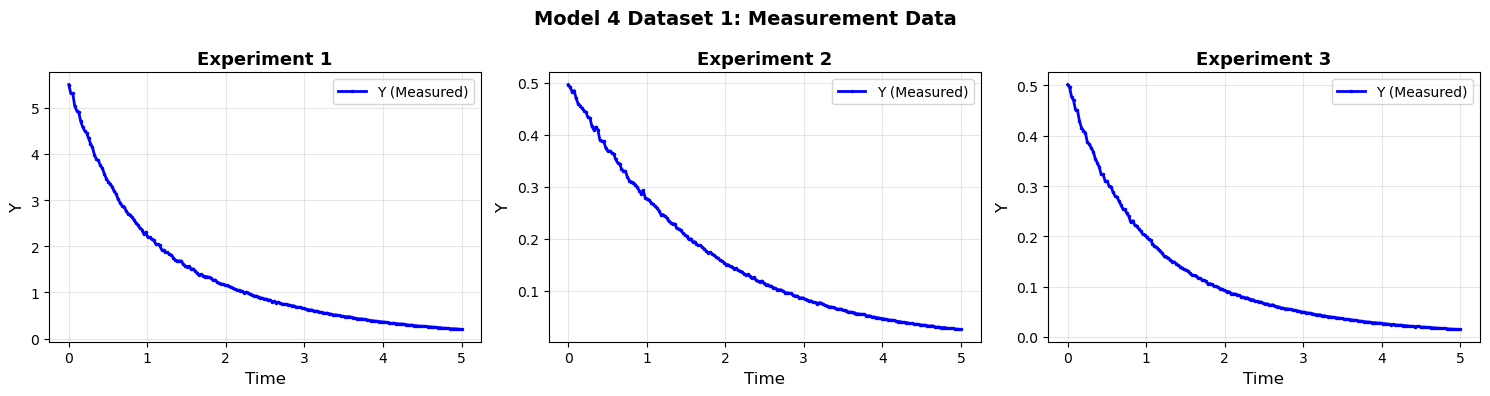

In [177]:
# Visualize all experiments
fig, axes = plt.subplots(1, n_experiments, figsize=(5*n_experiments, 4))
if n_experiments == 1:
    axes = [axes]

for i, exp_data in enumerate(experiments_data):
    ax = axes[i]
    y_idx = OBSERVED_INDICES[0]
    ax.plot(exp_data['t'], exp_data['y_noisy'][:, y_idx], 'b.-', 
            label=f'Y (Measured)', linewidth=2, markersize=3)
    ax.set_xlabel('Time', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title(f'Experiment {i+1}', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.suptitle(f'Model 4 Dataset {DATASET_NUMBER}: Measurement Data', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 2. Build UDE Model


In [178]:
# Create neural network
nn_model = create_neural_network(
    input_dim=NN_INPUT_DIM,
    output_dim=NN_OUTPUT_DIM,
    architecture=NN_ARCHITECTURE,
    **NN_CONFIG
)

print("Neural Network:")
print(nn_model)
print(f"\nParameters: {nn_model.count_parameters():,}")


Neural Network:
FlexibleNN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=32, bias=True)
    (9): ReLU()
    (10): Linear(in_features=32, out_features=32, bias=True)
    (11): ReLU()
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)

Parameters: 5,409


In [179]:
# Wrap NN to extract correct input from state vector
class NNWrapper(nn.Module):
    def __init__(self, nn, input_extractor, output_scale=0.01):
        super().__init__()
        self.nn = nn
        self.input_extractor = input_extractor
        self.output_scale = output_scale  # Scale output to prevent instability
    
    def forward(self, t, y):
        nn_input = self.input_extractor(y)
        # Concatenate time with state inputs
        if nn_input.dim() == 1:
            t_expanded = t.unsqueeze(0) if t.dim() == 0 else t
        else:
            t_expanded = t.expand(nn_input.shape[0], 1) if t.dim() == 0 else t.unsqueeze(-1).expand(nn_input.shape[0], 1)
        
        full_input = torch.cat([t_expanded, nn_input], dim=-1)
        output = self.nn(t, full_input)
        return output * self.output_scale  # Scale down the output

wrapped_nn = NNWrapper(nn_model, nn_input_extractor, output_scale=0.01)

# Add learnable parameters a and b (very conservative initialization)
a_learnable = nn.Parameter(torch.tensor(0.01))  # Very small initial guess
b_learnable = nn.Parameter(torch.tensor(0.1))  # Very small initial guess
KNOWN_PARAMS['a_learnable'] = a_learnable
KNOWN_PARAMS['b_learnable'] = b_learnable

# Create UDE
ude_model = create_ude(
    n_states=len(STATE_NAMES),
    ode_func=ude_ode_equations,
    neural_networks={NN_NAME: wrapped_nn},
    known_params=KNOWN_PARAMS
)

# Register parameters
ude_model.register_parameter('a_learnable', a_learnable)
ude_model.register_parameter('b_learnable', b_learnable)

print(f"\n✓ UDE Model created!")
print(f"  NN parameters: {ude_model.count_parameters()['total']}")
print(f"  Initial a: {a_learnable.item():.4f}")
print(f"  Initial b: {b_learnable.item():.4f}")



✓ UDE Model created!
  NN parameters: 5409
  Initial a: 0.0100
  Initial b: 0.1000


## 3. Train UDE (on all experiments)


In [180]:
# Create trainer
trainer = UDETrainer(
    ude_model=ude_model,
    optimizer_name=OPTIMIZER,
    learning_rate=LEARNING_RATE,
    scheduler_type=SCHEDULER_TYPE,
    scheduler_params=SCHEDULER_PARAMS,
    weight_decay=WEIGHT_DECAY,
    grad_clip=GRAD_CLIP,
    ode_solver=ODE_SOLVER,
    ode_rtol=ODE_RTOL,
    ode_atol=ODE_ATOL
)

print("✓ Trainer initialized")


✓ Trainer initialized


/opt/miniconda3/envs/himanshu-quant-research/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [181]:
# Train on all experiments
print(f"\n{'='*60}")
print(f"TRAINING ({N_EPOCHS} epochs) on {n_experiments} experiments")
print(f"{'='*60}\n")

# Convert weights to tensor if provided
weights_torch = torch.tensor(STATE_WEIGHTS, dtype=torch.float32) if STATE_WEIGHTS is not None else None

# Train on all experiments (batch training)
for epoch in range(1, N_EPOCHS + 1):
    epoch_loss = 0.0
    epoch_grad_norm = 0.0
    epoch_loss_per_state = None
    
    for exp_data in experiments_data:
        y0_torch = torch.tensor(exp_data['y0'], dtype=torch.float32)
        t_torch = torch.tensor(exp_data['t'], dtype=torch.float32)
        y_true_torch = torch.tensor(exp_data['y_noisy'], dtype=torch.float32)
        
        # Single training step
        loss_dict = trainer.train_step(y0_torch, t_torch, y_true_torch, weights=weights_torch, loss_type=LOSS_TYPE)
        epoch_loss += loss_dict['loss']
        epoch_grad_norm += loss_dict['grad_norm']
        
        # Accumulate loss per state
        if epoch_loss_per_state is None:
            epoch_loss_per_state = loss_dict['loss_per_state']
        else:
            epoch_loss_per_state += loss_dict['loss_per_state']
    
    # Average metrics across experiments
    epoch_loss /= n_experiments
    epoch_grad_norm /= n_experiments
    epoch_loss_per_state /= n_experiments
    
    # Record history
    trainer.history['loss'].append(epoch_loss)
    trainer.history['grad_norm'].append(epoch_grad_norm)
    trainer.history['loss_per_state'].append(epoch_loss_per_state)
    trainer.history['learning_rate'].append(trainer.scheduler.get_last_lr()[0] if trainer.scheduler else LEARNING_RATE)
    
    # Scheduler step (based on epoch loss)
    if trainer.scheduler:
        if isinstance(trainer.scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            trainer.scheduler.step(epoch_loss)
        else:
            trainer.scheduler.step()
    
    # Print progress
    if epoch == 1 or epoch % PRINT_EVERY == 0:
        lr = trainer.scheduler.get_last_lr()[0] if trainer.scheduler else LEARNING_RATE
        print(f"Epoch {epoch}/{N_EPOCHS} | Loss: {epoch_loss:.6f} | LR: {lr:.6f} | Grad: {epoch_grad_norm:.4f}")

print(f"\n✓ Training complete!")
print(f"  Learned a: {ude_model.a_learnable.item():.4f}")
print(f"  Learned b: {ude_model.b_learnable.item():.4f}")



TRAINING (500 epochs) on 3 experiments

Epoch 1/500 | Loss: 0.027624 | LR: 0.001000 | Grad: 0.0274
Epoch 15/500 | Loss: 0.026646 | LR: 0.001000 | Grad: 0.0268
Epoch 30/500 | Loss: 0.021390 | LR: 0.001000 | Grad: 0.0506
Epoch 45/500 | Loss: 0.001047 | LR: 0.001000 | Grad: 0.0486
Epoch 60/500 | Loss: 0.000624 | LR: 0.001000 | Grad: 0.0077
Epoch 75/500 | Loss: 0.000591 | LR: 0.001000 | Grad: 0.0035
Epoch 90/500 | Loss: 0.000573 | LR: 0.001000 | Grad: 0.0027
Epoch 105/500 | Loss: 0.000561 | LR: 0.001000 | Grad: 0.0022
Epoch 120/500 | Loss: 0.000550 | LR: 0.001000 | Grad: 0.0019
Epoch 135/500 | Loss: 0.000539 | LR: 0.001000 | Grad: 0.0017
Epoch 150/500 | Loss: 0.000527 | LR: 0.001000 | Grad: 0.0015
Epoch 165/500 | Loss: 0.000515 | LR: 0.001000 | Grad: 0.0014
Epoch 180/500 | Loss: 0.000502 | LR: 0.001000 | Grad: 0.0013
Epoch 195/500 | Loss: 0.000488 | LR: 0.001000 | Grad: 0.0013
Epoch 210/500 | Loss: 0.000474 | LR: 0.001000 | Grad: 0.0013
Epoch 225/500 | Loss: 0.000456 | LR: 0.001000 | Grad

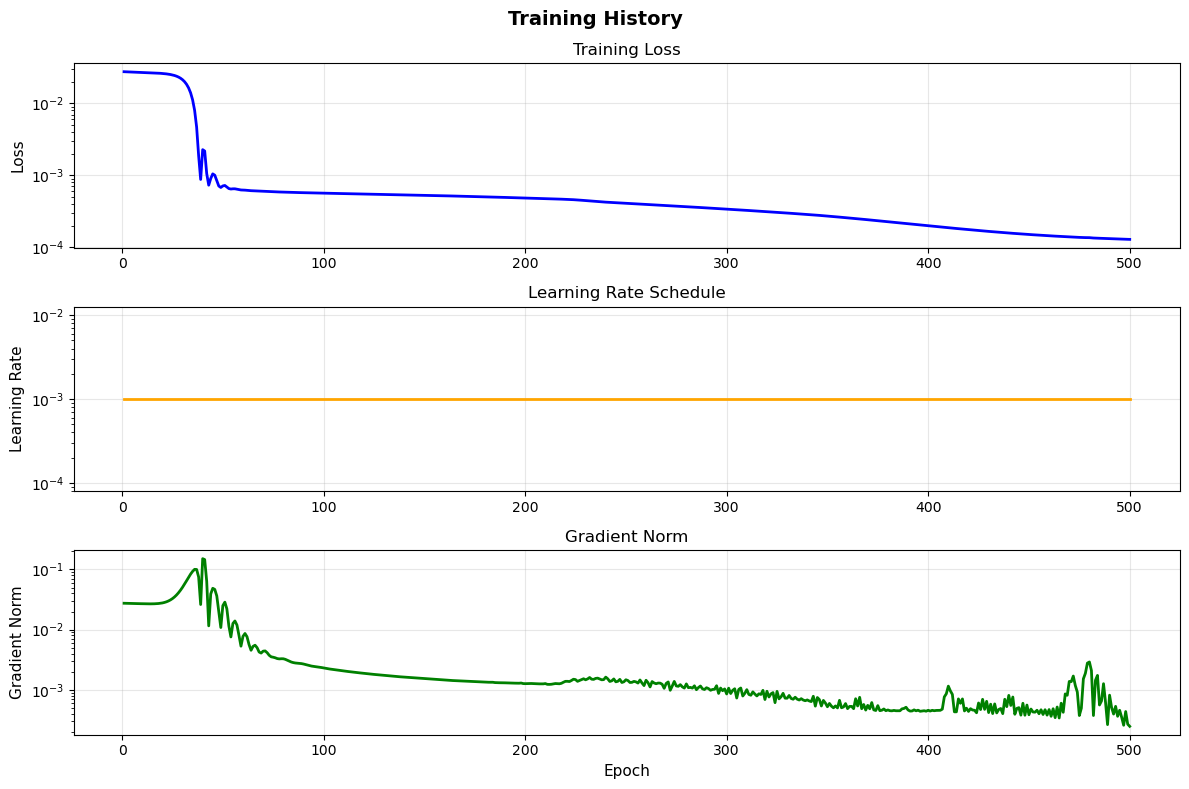

In [182]:
# Plot training history
history = trainer.get_history()
evaluator = UDEEvaluator(ude_model, STATE_NAMES)
evaluator.plot_training_history(history)


## 4. Evaluate UDE Performance


In [183]:
# Get predictions for all experiments
predictions = []
for exp_data in experiments_data:
    y0_torch = torch.tensor(exp_data['y0'], dtype=torch.float32)
    t_torch = torch.tensor(exp_data['t'], dtype=torch.float32)
    
    with torch.no_grad():
        y_pred = trainer.forward_solve(y0_torch, t_torch).numpy()
    
    predictions.append(y_pred)
    
    # Compute metrics (only for Y, the observed state)
    y_idx = OBSERVED_INDICES[0]
    y_true = exp_data['y_true'][:, y_idx]
    y_pred_state = y_pred[:, y_idx]
    
    mse = np.mean((y_pred_state - y_true)**2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(y_pred_state - y_true))
    
    print(f"\nExperiment {exp_data['exp_id']+1} Metrics (for Y):")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")



Experiment 1 Metrics (for Y):
  MSE:  0.000357
  RMSE: 0.018904
  MAE:  0.011925

Experiment 2 Metrics (for Y):
  MSE:  0.000010
  RMSE: 0.003236
  MAE:  0.002232

Experiment 3 Metrics (for Y):
  MSE:  0.000017
  RMSE: 0.004122
  MAE:  0.003589


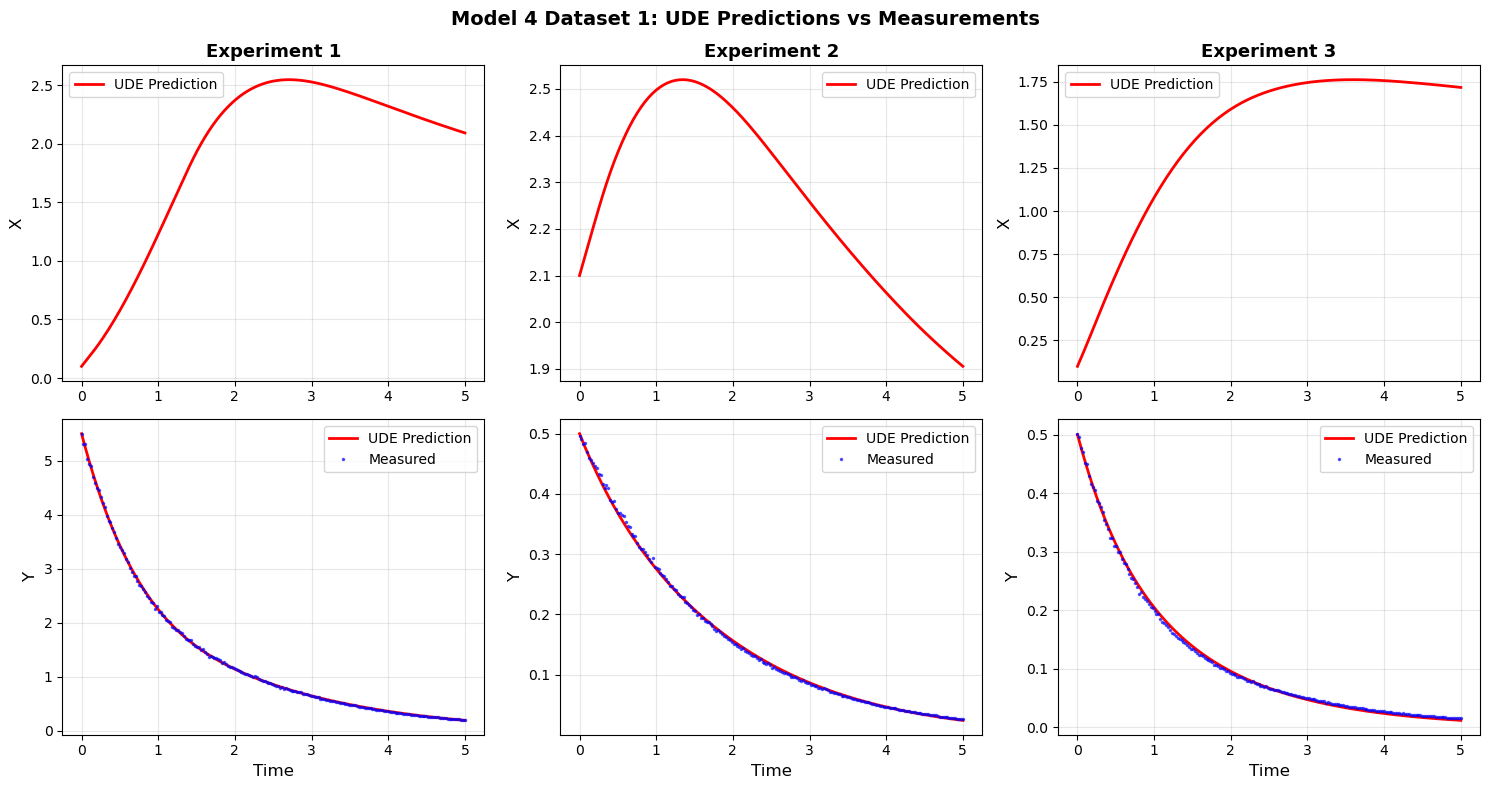

In [184]:
# Plot trajectories for all experiments
fig, axes = plt.subplots(len(STATE_NAMES), n_experiments, 
                         figsize=(5*n_experiments, 4*len(STATE_NAMES)))

if n_experiments == 1:
    axes = axes.reshape(-1, 1)

for exp_idx, (exp_data, y_pred) in enumerate(zip(experiments_data, predictions)):
    t = exp_data['t']
    y_true = exp_data['y_true']
    
    for state_idx, name in enumerate(STATE_NAMES):
        ax = axes[state_idx, exp_idx]
        ax.plot(t, y_pred[:, state_idx], 'r-', label='UDE Prediction', linewidth=2)
        
        # Only plot measurements for Y
        if state_idx == OBSERVED_INDICES[0]:
            ax.plot(t, y_true[:, state_idx], 'b.', label='Measured', alpha=0.6, markersize=3)
        
        ax.set_ylabel(name, fontsize=12)
        if state_idx == 0:
            ax.set_title(f'Experiment {exp_idx+1}', fontsize=13, fontweight='bold')
        if state_idx == len(STATE_NAMES) - 1:
            ax.set_xlabel('Time', fontsize=12)
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle(f'Model 4 Dataset {DATASET_NUMBER}: UDE Predictions vs Measurements', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## 5. Visualize Learned Function f(Y)


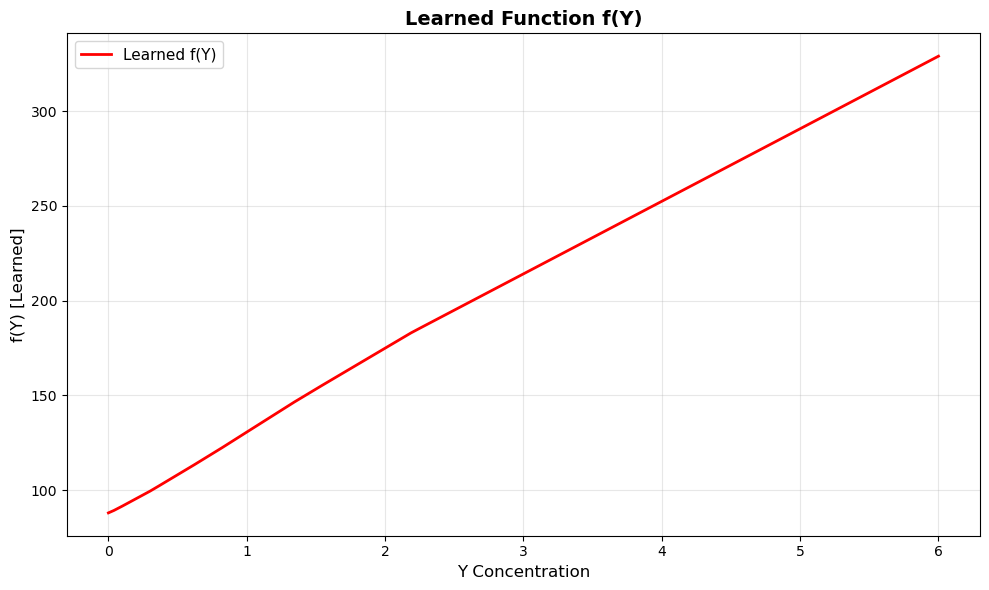

In [185]:
# Visualize the learned f(Y) function
t_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)
y_range = torch.tensor(FUNCTION_INPUT_RANGE.reshape(-1, 1), dtype=torch.float32)

# Create full input [t, Y]
full_input = torch.cat([t_range, y_range], dim=-1)

with torch.no_grad():
    f_Y_learned = nn_model(t_range[:, 0], full_input).numpy()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(FUNCTION_INPUT_RANGE, f_Y_learned, 'r-', linewidth=2, label='Learned f(Y)')
ax.set_xlabel(FUNCTION_INPUT_NAME, fontsize=12)
ax.set_ylabel(FUNCTION_OUTPUT_NAME, fontsize=12)
ax.set_title('Learned Function f(Y)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. Parameter Summary


In [186]:
# Display learned parameters
print("\n" + "="*60)
print("LEARNED PARAMETERS")
print("="*60)
print(f"\nParameter a (growth rate):")
print(f"  Learned value: {ude_model.a_learnable.item():.4f}")
print(f"\nParameter b (coupling strength):")
print(f"  Learned value: {ude_model.b_learnable.item():.4f}")
print("\nNeural Network f(Y):")
print(f"  Total parameters: {nn_model.count_parameters()}")
print(f"  Architecture: {NN_INPUT_DIM} -> {' -> '.join(map(str, NN_CONFIG['hidden_dims']))} -> {NN_OUTPUT_DIM}")
print(f"  Activation: {NN_CONFIG['activation']}")
print("="*60)



LEARNED PARAMETERS

Parameter a (growth rate):
  Learned value: 0.1843

Parameter b (coupling strength):
  Learned value: 0.1727

Neural Network f(Y):
  Total parameters: 5409
  Architecture: 2 -> 32 -> 32 -> 32 -> 32 -> 32 -> 32 -> 1
  Activation: relu
